# Training a New iXnos model in pytorch

## Development for `scripts/ixnos_retrain.py`

In [1]:
import torch
from torch import nn
import pickle
from collections import OrderedDict
import numpy as np
from Bio import SeqIO
import pandas as pd
from scipy.stats import pearsonr


class iXnos(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Linear(760, 200),
            nn.Tanh(),
            nn.Linear(200, 1),
            nn.ReLU(),
        )
    
    def forward(self, x):
        output = self.layers(x)
        return output 

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = iXnos().to(device)

Using cpu device


In [2]:
ALPHA = "ACGT"  # Defines the possible nucleotides
NTS = ["A", "C", "G", "T"]  # Nucleotide list
CODONS = [x + y + z for x in ALPHA for y in ALPHA for z in ALPHA]
COD2ID = {codon: idx for idx, codon in enumerate(CODONS)}  # Codon to ID mapping
ID2COD = {idx: codon for codon, idx in COD2ID.items()}  # ID to Codon mapping
NT2ID = {nt: idx for idx, nt in enumerate(NTS)}  # Nucleotide to ID mapping
ID2NT = {idx: nt for nt, idx in NT2ID.items()}  # ID to Nucleotide mapping
NT_INDICES = np.arange(-15, 15)  # Nucleotide indices window
CODON_INDICES = np.arange(-5, 5)  # Codon indices window


In [3]:
class Experiment():
    # Class Constants: Indexing for codons / nucleotides for encoding
    ALPHA = "ACGT"  
    NTS = ["A", "C", "G", "T"]
    # Indices for nucleotide and codon windows
    NT_INDICES = np.arange(-15, 15)  # Nucleotide indices window
    CODON_INDICES = np.arange(-5, 5)  # Codon indices window
    def __init__(self, y_tr, y_te, gdf_path):
        self.ydf = ydf
        self.gdf_path = gdf_path
        self.gdf = self.load_gdf()
        # Define CODONS, COD2ID, and other mappings here in __init__
        self.CODONS = [x + y + z for x in self.ALPHA for y in self.ALPHA for z in self.ALPHA]
        self.COD2ID = {codon: idx for idx, codon in enumerate(self.CODONS)}
        self.ID2COD = {idx: codon for codon, idx in self.COD2ID.items()}
        self.NT2ID = {nt: idx for idx, nt in enumerate(self.NTS)}
        self.ID2NT = {idx: nt for nt, idx in self.NT2ID.items()}
        # Encode data
        self.ydf["encoding"] = self.ydf.apply(self.get_inputs, axis=1)
    

    def load_gdf(self):
        records = list(SeqIO.parse(self.gdf_path, "fasta"))
        gdf = pd.DataFrame({
                'ID': [record.id for record in records],
                'seq': [str(record.seq) for record in records]
            }).set_index("ID")
        genes_from_codons = pd.DataFrame(self.ydf.groupby("gene")["cod_seq"].agg(''.join))
        gdf.loc[genes_from_codons.index, "cod_gene"] = genes_from_codons["cod_seq"].values
        gdf = gdf.dropna()
        assert all(gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1))
        # gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1)
        gdf["start"] = gdf.apply(lambda row: row['seq'].find(row['cod_gene']), axis=1)
        return gdf
    
    @staticmethod
    def encode(val, ref:dict):
        # Given a dict (ref) mapping values to indices a value (val), 
        # return a 1-hot-encoded numpy array of that value
        # e.g. encode(A , {A : 0, T : 1, ...}) -> [1, 0, 0, 0]
        output = np.zeros(len(ref))
        output[ref[val]] = 1
        return output
    
    def get_inputs(self, row):
        # Get input vectors for a given row of the y dataframe.
        gdf_gene = self.gdf.loc[row["gene"]]
        gdf_seq = gdf_gene["seq"]
        # Get index of E site in fasta sequence
        esite_index = (row["cod_idx"] - 20) * 3 + gdf_gene["start"] 
        # Find the nucleotides in the window
        footprint_nt = gdf_seq[
            esite_index + NT_INDICES[0]:
            esite_index + NT_INDICES[-1] + 1]
        # Convert nt string into codons 
        # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
        footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
        # Assemble input tensor
        codon_vector = np.concatenate([encode(i, self.COD2ID) for i in footprint_codons])
        nt_vector = np.concatenate([encode(i, self.NT2ID) for i in footprint_nt])
        input_vector = np.concatenate([codon_vector, nt_vector])
        input_vector = torch.from_numpy(input_vector).to(torch.float32)
        return input_vector


In [3]:
def load_gdf(ydf, gdf_path):
    # Loads the dataframe with gene sequences and finds the (truncated) 
    # CDS we want to feed to iXnos within that sequence
    records = list(SeqIO.parse(gdf_path, "fasta"))
    gdf = pd.DataFrame({
            'ID': [record.id for record in records],
            'seq': [str(record.seq) for record in records]
        }).set_index("ID")
    genes_from_codons = pd.DataFrame(ydf.groupby("gene")["cod_seq"].agg(''.join))
    gdf.loc[genes_from_codons.index, "cod_gene"] = genes_from_codons["cod_seq"].values
    gdf = gdf.dropna()
    assert all(gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1))
    # gdf.apply(lambda row: row["cod_gene"] in row["seq"], axis=1)
    gdf["start"] = gdf.apply(lambda row: row['seq'].find(row['cod_gene']), axis=1)
    return gdf

def encode(val, ref:dict):
    # Given a dict (ref) mapping values to indices a value (val), 
    # return a 1-hot-encoded numpy array of that value
    # e.g. encode(A , {A : 0, T : 1, ...}) -> [1, 0, 0, 0]
    output = np.zeros(len(ref))
    output[ref[val]] = 1
    return output

def get_inputs(row):
    # Get input vectors for a given row of the y dataframe.
    gdf_gene = gdf.loc[row["gene"]]
    gdf_seq = gdf_gene["seq"]
    # Get index of E site in fasta sequence
    esite_index = (row["cod_idx"] - 20) * 3 + gdf_gene["start"] 
    # Find the nucleotides in the window
    footprint_nt = gdf_seq[
        esite_index + NT_INDICES[0]:
        esite_index + NT_INDICES[-1] + 1]
    # Convert nt string into codons 
    # NOTE: assumes your nt footprint is an in frame CDS containing just the codons we wanna look at
    footprint_codons = [footprint_nt[i:i+3] for i in range(0, len(footprint_nt), 3)]
    # Assemble input tensor
    codon_vector = np.concatenate([encode(i, COD2ID) for i in footprint_codons])
    nt_vector = np.concatenate([encode(i, NT2ID) for i in footprint_nt])
    input_vector = np.concatenate([codon_vector, nt_vector])
    input_vector = torch.from_numpy(input_vector).to(torch.float32)
    return input_vector

iwasaki_dir = "iXnos/expts/iwasaki"
ydf_te = pd.read_csv(
    f"{iwasaki_dir}/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')
ydf_tr = pd.read_csv(
    f"{iwasaki_dir}/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep='\t')
genes_te = ydf_te["gene"].unique()
genes_tr = ydf_tr["gene"].unique()

ydf = pd.concat([ydf_te, ydf_tr]).sort_values(by=["gene", "cod_idx"])
gdf_path = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
gdf = load_gdf(ydf, gdf_path)

In [4]:
ydf["X"] = ydf.apply(get_inputs, axis=1)

In [5]:
X_tr, y_tr = ydf.loc[ydf["gene"].isin(genes_tr), ["X", "scaled_cts"]].values.T.tolist()
X_te, y_te = ydf.loc[ydf["gene"].isin(genes_te), ["X", "scaled_cts"]].values.T.tolist()

X_tr = torch.stack(X_tr)
y_tr = torch.tensor(y_tr)
X_te = torch.stack(X_te)
y_te = torch.tensor(y_te)



In [6]:
epochs = 70
learning_rate = 0.01
lr_decay = 32
loss_fn = torch.nn.MSELoss()
# optimizer = None#torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# LR decay function
lr_lambda = lambda epoch: 1 / (1 + float(epoch) / lr_decay)
# LambdaLR scheduler: Use lr_lambda to apply custom decay
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [7]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
batch_size = 40
batch_size = 500
dataset_tr = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataset_te = TensorDataset(X_te, y_te)
test_loader = DataLoader(dataset_te, batch_size=batch_size, shuffle=True)

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X)  # Forward pass
        outputs = outputs.squeeze(1) # Squeeze outputs to be right dims for comparison to y w loss fn
        loss = loss_fn(outputs, y)  # Compute the loss
        total_loss += loss.item()
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step() # Update parameters using Nesterov SGD
    scheduler.step() # Update learning rate using scheduler
    avg_loss = total_loss / len(dataloader)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Average Loss: {avg_loss} | Learning Rate: {current_lr:.6f}", end = " ")
    return avg_loss

def test_loop(dataloader, model, loss_fn):
    model.eval()
    predicted_counts, actual_counts = [], []
    total_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Predict scaled counts
            outputs = model(X)
            outputs = outputs.squeeze(1)
            predicted_counts.append(outputs.cpu().numpy())
            actual_counts.append(y.cpu().numpy())
            # Compute loss
            loss = loss_fn(outputs, y)
            total_loss += loss.item()  # Accumulate the loss for this batch

        predicted_counts = np.concatenate(predicted_counts)
        actual_counts = np.concatenate(actual_counts)
        # Find pearson correlation between predictions and actual
        pearson_r, _ = pearsonr(predicted_counts, actual_counts)
        avg_loss = total_loss / len(dataloader)
    print(f"| Pearson Correlation: {pearson_r:.4f} | Test Loss: {avg_loss:.4f}")
    return avg_loss, pearson_r

# if epoch % 10 == 0:  # Print every 10 epochs
#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")


In [9]:
# n_epochs = 10
loss_tr, loss_te, corr_te = [], [], [] 

for epoch in range(epochs):
    print(f"Epoch {epoch}:", end = " ")
    l_tr = train_loop(train_loader, model, loss_fn, optimizer)
    loss_tr.append(l_tr)
    # if (epoch + 1) % 5 == 0:
    l_te, r_te = test_loop(test_loader, model, loss_fn)
    loss_te.append(l_te)
    corr_te.append(r_te)
    # else:
    #     print()

Epoch 0: Average Loss: 2.8368406133218245 | Learning Rate: 0.009697 | Pearson Correlation: 0.4346 | Test Loss: 3.4704
Epoch 1: Average Loss: 2.6415709052423035 | Learning Rate: 0.009412 | Pearson Correlation: 0.4498 | Test Loss: 3.4543
Epoch 2: Average Loss: 2.6185350421101155 | Learning Rate: 0.009143 | Pearson Correlation: 0.4472 | Test Loss: 3.4336
Epoch 3: Average Loss: 2.6009563240740032 | Learning Rate: 0.008889 | Pearson Correlation: 0.4574 | Test Loss: 3.4121
Epoch 4: Average Loss: 2.587784882145699 | Learning Rate: 0.008649 | Pearson Correlation: 0.4631 | Test Loss: 3.3752
Epoch 5: Average Loss: 2.564172129438381 | Learning Rate: 0.008421 | Pearson Correlation: 0.4728 | Test Loss: 3.3452
Epoch 6: Average Loss: 2.5272781346181428 | Learning Rate: 0.008205 | Pearson Correlation: 0.4735 | Test Loss: 3.3427
Epoch 7: Average Loss: 2.4926215690193754 | Learning Rate: 0.008000 | Pearson Correlation: 0.4913 | Test Loss: 3.2626
Epoch 8: Average Loss: 2.458122618270643 | Learning Rate: 

In [15]:
df_res = pd.DataFrame({
    "loss_tr": loss_tr, 
    "loss_te": loss_te, 
    "corr_te": corr_te,})
df_res.index.name = "epoch"
# df_res

## Evaluate results from script

In [15]:
df_res = pd.read_csv("models/ixnos_retrained_loss_by_epoch.csv", index_col=0)
epochs = len(df_res)
loss_tr, loss_te, corr_te = df_res.T.values

In [16]:
df_res

,loss_tr,loss_te,corr_te
epoch,,,
0,NaN,5.187467,0.028543
1,2.827941,3.477457,0.436025
2,2.636188,3.431362,0.449446
3,2.617219,3.417584,0.454099
4,2.601508,3.399523,0.455077
...,...,...,...
66,1.174816,2.864357,0.588805
67,1.163754,2.848984,0.590966
68,1.157087,2.878615,0.587349


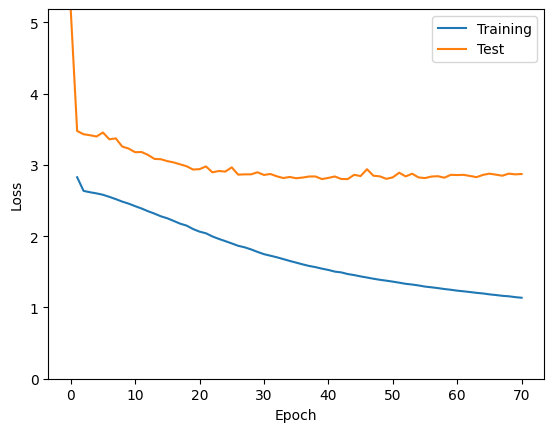

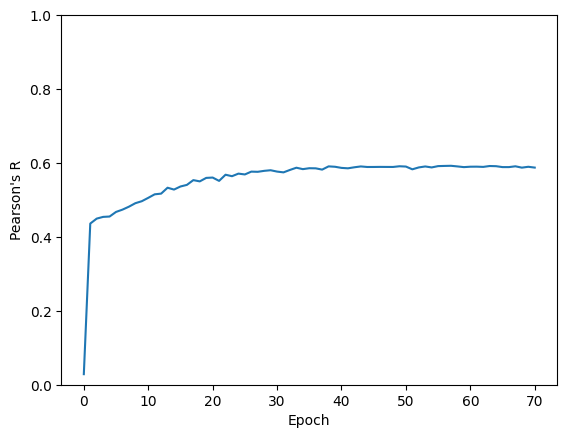

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), loss_tr, label="Training")
plt.plot(range(epochs), loss_te, label="Test")
plt.ylim(0, max([max(i) for i in [loss_te, loss_tr]]))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(range(epochs), corr_te)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Pearson's R")
plt.show()

In [29]:
costs = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/te_cost_by_epoch.pkl"
with open(costs, 'rb') as file:
    costs = pickle.load(file, encoding='bytes')

costs

[5.0016597492073425,
 3.4883333257258204,
 3.4571354842536866,
 3.43225837303234,
 3.4218033132548245,
 3.4082441064672175,
 3.367079132485529,
 3.343800336212112,
 3.282504279740786,
 3.2487283111390695,
 3.213696347370882,
 3.1698406224792257,
 3.128954742530645,
 3.1276308739018095,
 3.095006888916938,
 3.0223863248227074,
 3.005366122577526,
 2.965988936270082,
 2.960624215900702,
 2.9411644667413306,
 2.939253966095433,
 2.9078234493897175,
 2.8768093548685503,
 2.867360042223028,
 2.858397067431947,
 2.883943957417684,
 2.8576792290423354,
 2.83122700387265,
 2.843927986104022,
 2.8524925383626476,
 2.8080304435057846,
 2.820173173353002,
 2.812739749195965,
 2.819736693704957,
 2.8186155473336263,
 2.811466394680076,
 2.822033246830023,
 2.8078499313384437,
 2.8084141092933006,
 2.812291080361439,
 2.7974969538681473,
 2.8142474986087596,
 2.802581276169171,
 2.8109215026091574,
 2.8337878536435572,
 2.8091871970336855,
 2.827137161068606,
 2.8164276841486617,
 2.816175723523031